# Structure from Motion

This project uses matrix factorization to reconstruct a set of 3D points from correspondences in a set of images. The final result is a texture-mapped set of quadrilateral planar regions.

In this project you will take a set of images of an object, identify correspondence points that are visible in all images, and use these correspondences to reconstruct the 3D structure of the object. You will also identify quadrilateral planar regions in the correspondences for texture mapping.

You need to upload `input.zip` before running the cells. `image.zip` is a zip file consisting of:

1. image files (jpeg / png),
2. `tracked_points.txt`, and
3. `quads.txt`.

`tracked_points.txt` is a text file listing corresponding 2D points in each image. The format is

```
filename1 u11 v11 u12 v12 ...
filename2 u21 v21 u22 v12 ...
...
```

where $\mathrm{filename}_i$  is the filename of an image in `images.zip` and $(u_{ij}, v_{ij})$ is the the $j$th corresponding point location in the $i$th image. That is, the $j$th point appears at `(u1j, v1j)` in `filename1` and the same point moves to `(u2j, v2j)` in `filename2`, and so forth.  You may use `track_points.py` to generate this file (see below).

`quads.txt` is a text file listing a quadruplet of corresponding points per line to define a 3D surface. For example,

```
1 2 3 4
5 6 7 8
```

tells that the quadruplet `(u?1, v?1)`-`(u?2, v?2)`-`(u?3, v?3)`-`(u?4, v?4)` forms a 3D plane in the scene, and `(u?5, v?5)`-`(u?6, v?6)`-`(u?7, v?7)`-`(u?8, v?8)` defines another one.




# Tracking Points

This project requires a set of correspondences and a set of correspondence indices which form planar 3D regions. For the test data, both of these are provided for you. When you use your own images, you will need to track many points through each image in the set. The points you choose to track must be visible in all of the images. The provided `track_points.py` file is invaluable for this task, as you would otherwise need to load all of the images in an editor and find pixel coordinates for each correspondence in every image manually. The point tracker requires the OpenCV Python bindings. You can run the point tracker like this:

```shell
python track_points.py N_POINTS_TO_TRACK IMAGE_1 IMAGE_2 ... IMAGE_N
```

You will be shown the sequence of images N_POINTS_TO_TRACK times. Each time you go through the images, you will be tracking a single point through all images. Clicking on a point in the image will advance to the next. When you have tracked the point in all frames, it will appear in the image with an index number next to it. This signals that you should start tracking another point. Make sure you can actually identify N_POINTS_TO_TRACK correspondence points in each image. Output is saved to `tracked_points.txt` in the current directory.

Once you have identified the correspondences, you will need to provide a list of correspondence indices for quadrilateral planar regions. The format for this list is 4 correspondence numbers per line, separated by spaces. Each line should contain 4 points on a planar region. To help you find these planar points, you can look at the newly-saved correspondence images `????_correspondences.{jpg,png}` in the same folder as the input images. Identify planar regions composed of 4 points and write the 4 point indices into a file. Use the numbers shown in the images when you make the file. The test data contains an example in `quads.txt`.

## Notice for Colaboratory Users

The provided `track_points.py` **DOES NOT RUN** in Colaboratory, since it cannot open GUI for you.  Instead, run this script locally in your PC.  You need the OpenCV python binding installed. i.e.,

```python
import cv2
print(cv2.__version__)
```

should output `'3.4.2'` for example. [Anaconda](https://www.anaconda.com/download/) users can install OpenCV by `conda`:

```shell
> conda install opencv
```


# Code Skeleton

Your grade will be based on code that you add to complete the skeleton cell below. Though it should not be necessary, you are free to add additional functions as you see fit to complete the assignment. You are not, however, allowed to import additional libraries or submit separate code files. Everything you will need has been included in the cell. Once finished implementation, the cell next to this skeleton can be used to run this skeleton cell on a set of images. Usage is described below.

All image parameters for skeleton functions are passed as 3D numpy arrays with shape `(height, width, 3)` for color images. You should return images in the same format.


In [7]:
import numpy as np
import numpy.linalg
import scipy as sp
import scipy.linalg

from cv2 import findHomography, warpPerspective

def build_W(points):
    """Build the mean-centered point matrix W. points should be an array with shape
    (num_frames, num_points, 2)."""
    F_ = points.shape[0]
    N_ = points.shape[1]

    W = np.zeros((2 * F_, N_), dtype=np.float32)

    points_ = points - points.mean(axis=1).reshape((F_, 1, 2))  # F,N,2

    for i_ in range(F_):
        W[i_, :] = points_[i_, :, 0]
        W[i_ + F_, :] = points_[i_, :, 1]

    return W


def compute_RS(W):
    """Compute the matrices R^hat and S^hat from W using the SVD."""
    U, S, VT = np.linalg.svd(W)
    U, VT = U[:, :3], VT[:3, :]
    S_ = np.diag(np.sqrt(S[:3]))
    Rh, Sh = U @ S_, S_ @ VT
    return Rh, Sh


def solve_Q(ih, jh):
    """Solve for Q that satisfies the unit-vector and orthogonality constraints
    on ih and jh."""
    # Build A and b
    A = np.zeros((3 * len(ih), 6), dtype=np.float32)  # 3F,6
    b = np.zeros(3 * len(ih), dtype=np.float32)  # 3F,1

    index_A = 0
    for i_ in range(len(ih)):
        A[index_A] = [ih[i_, 0] ** 2, ih[i_, 1] ** 2, ih[i_, 2] ** 2, 2 * ih[i_, 0] * ih[i_, 1], 2 * ih[i_, 2] * ih[i_, 1],
                      2 * ih[i_, 0] * ih[i_, 2]]
        b[index_A] = 1
        index_A = index_A + 1

        A[index_A] = [jh[i_, 0] ** 2, jh[i_, 1] ** 2, jh[i_, 2] ** 2, 2 * jh[i_, 0] * jh[i_, 1], 2 * jh[i_, 2] * jh[i_, 1],
                      2 * jh[i_, 0] * jh[i_, 2]]
        b[index_A] = 1
        index_A = index_A + 1

        A[index_A] = [jh[i_, 0] * ih[i_, 0], jh[i_, 1] * ih[i_, 1], jh[i_, 2] * ih[i_, 2],
                      ih[i_, 0] * jh[i_, 1] + jh[i_, 0] * ih[i_, 1], jh[i_, 2] * ih[i_, 1] + ih[i_, 2] * jh[i_, 1],
                      jh[i_, 0] * ih[i_, 2] + ih[i_, 0] * jh[i_, 2]]
        b[index_A] = 0
        index_A = index_A + 1

    # Solve for c via least squares.
    c = (np.linalg.pinv(A.T @ A) @ A.T @ b).reshape(6)  # ,6,1
    # c, res, rnk, s = np.linalg.lstsq(A, b)


    # Form C from c
    C = np.array([[c[0], c[3], c[5]],
            [c[3], c[1], c[4]],
            [c[5], c[4], c[2]]], dtype=np.float32)


    # tell C is postive definite or not
    assert np.all(np.linalg.eig(C)[
                      0] > 0), " the computed C is not positive definite and can not be solved by cholesky decomposition"

    # Solve for Q and return it. use cholesky decomposition
    Q = np.linalg.cholesky(C)  # 3,3
    return Q


def sfm(points):
    """Run the SfM factorization on a set of points. points will be an array
    with shape (num_frames, num_points, 2) in order of corresponding point in 3D real world"""
    F = points.shape[0]

    # Construct the required W/Rh/Sh matrices.
    W = build_W(points)  # 2F,N
    Rh, Sh = compute_RS(W)  # (2F,3) (3,N)

    # Get ih/jh from Rh and use them to find Q.
    ih, jh = Rh[:F, :], Rh[F:, :]  # F,3,
    Q = solve_Q(ih, jh)  # 3,3

    # Use Q, Rh, and Sh to get R and S.
    R = Rh @ Q  # 2F,3
    S = np.linalg.pinv(Q) @ Sh  # 3,N

    # Extract the F 2x3 rotation matrices from R and form an (F,2,3) array of
    # rotation matrices.
    Rotation = np.zeros((len(points), 2, 3), dtype=np.float32)  # F,2,3
    for i_ in range(len(Rotation)):
        Rotation[i_, 0, :] = R[i_]
        Rotation[i_, 1, :] = R[i_ + F]

    # Build an orthonormal matrix that rotates the first R matrix into an
    # identity matrix. Under discussion
    O_ = np.zeros((3, 3), dtype=np.float32)
    O_[:, 0] = Rotation[0, 0, :]
    O_[:, 1] = Rotation[0, 1, :]

    u, s, vh = np.linalg.svd(Rotation[0])  # vh 3,3
    O_[:, 2] = vh[-1, :] / np.sqrt(np.sum(vh[-1, :] ** 2))

    # Apply the computed rotation matrix to the rotation matrices and the
    # points in S.
    Rotation = Rotation @ O_  # F,2,3
    S = np.linalg.pinv(O_)@ S  # 3,N

    # Return the R matrices and an ** Nx3 ** matrix containing the
    # reconstructed 3D points (note that S is 3xN).
    return Rotation, S.T

def get_texture(images, region_points, texture_size=256):
    """Given a set of images and 4 points for each image representing a
    quadrilateral planar region, extract a square texture of size texture_size
    containing the pixel values within the region averaged over all of the
    images You may use the imported OpenCV findHomography and warpPerspective
    functions.
    images F,(H,W,3)
    region_points F,4,2"""

    # Build a (4,2) array of X/Y texture coordinates for a
    # texture_size x texture_size square. The coordinates should
    # start at the top left (0,0) and proceed clockwise.
    target_points=np.array([[0,0],[texture_size-1,0],[texture_size-1,texture_size-1],[0,texture_size-1]],dtype=np.float32)
    
    textures=[]
    for image, rect_points in zip(images, region_points):
        # Find a homography that warps the points for the current region to the
        # texture coordinates.
        H,_ = findHomography(rect_points, target_points)

        # Warp the image with the homography to obtain the texture for this
        # image and append it to the list of textures.
        image_temp=warpPerspective(image,H,(texture_size,texture_size))
        textures.append(image_temp)
        

    # Return the mean texture across the images.
    texture=np.array(textures).mean(axis=0) # F,W,W,3
    return texture


# SfM

Now you can run the next cell to test your implementation.  Upload `input.zip` first, and then start the cell.

The result will be a 3D model packed into a single ZIP file named `output.zip`.  Your browser starts downloading it automatically (or you may be prompted for the directory / filename).  Once downloaded, extract all files  into a directory.  `output.zip` should contain

* `mesh.obj`,
* `textures/textures.mtl`,
* `textures/texture%d.jpg`.

`mesh.obj` is a 3D mesh model (geometry), and `textures` directory contains textures for each of the quadrilateral planar regions identified in the mesh.
The `mesh.obj` file together with the textures directory can be viewed in any program that can open [OBJ-format 3D models](https://en.wikipedia.org/wiki/Wavefront_.obj_file), such as [Meshlab](http://www.meshlab.net/).
Windows10 users can use [3D Viewer](https://www.microsoft.com/en-us/store/p/windows-view-3d/9nblggh42ths) which is likely to be preinstalled or available in Microsoft Store. (*do not use Paint 3D.  it cannot open texture files automatically due to some limitations, though it might be associated as the default app for .obj files.*)

The cell also generates image files in `reprojections/` directory .  `????_reprojected.jpg` shows the 3D points projected back into each image (can be useful for debugging).  Colab uses should press `REFRESH` button first to update the file browser, and can double-click the filename to preview it.

![3D Viewer](https://www.dropbox.com/s/kccn8pbe9s10kx3/Clipboard01.jpg?dl=1)



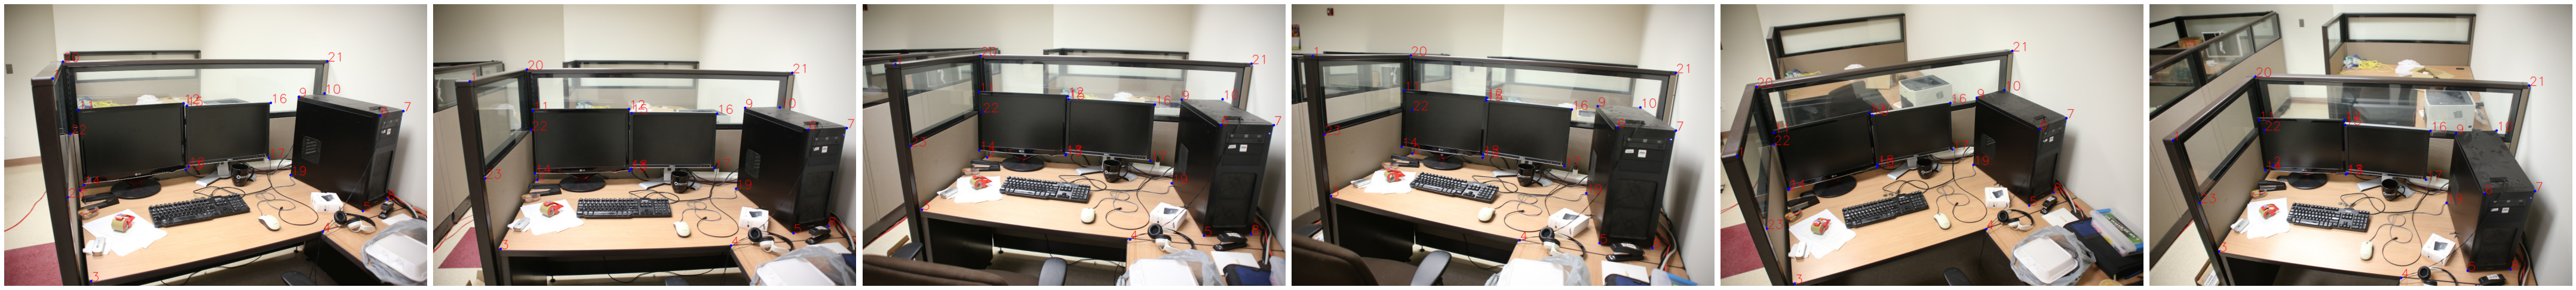

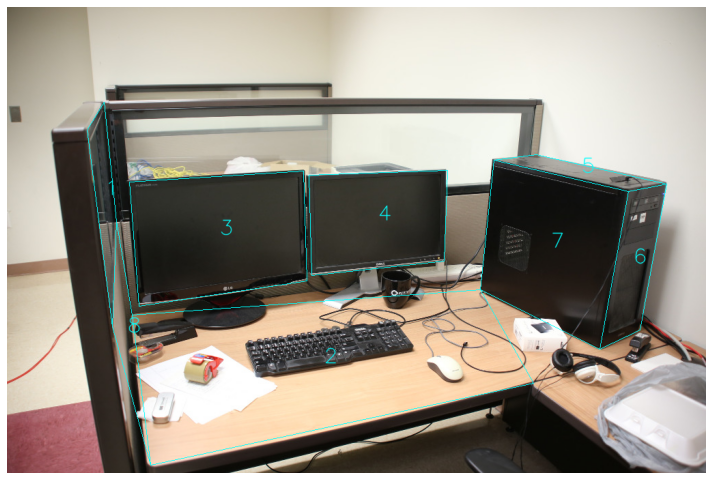

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:

#@title SfM
INPUT_ZIP = "input.zip" #@param {type:"string"}

import numpy as np
import matplotlib.pyplot as plt
import cv2
import zipfile
import os
import math

try:
    LINE_AA = cv2.LINE_AA
except:
    LINE_AA = cv2.CV_AA

    
def find_file_z(zf, filename):
    """ find a file in zip """
    for i in zf.namelist():
        if filename == i or filename == os.path.basename(i):
            return i
    return None

def imread_z(zf, filename, flag=cv2.IMREAD_UNCHANGED):
    return cv2.imdecode(np.frombuffer(zf.read(find_file_z(zf, filename)), dtype='uint8'), flag)

def readlines_z(zf, filename):
    return [_.decode('utf-8') for _ in zf.open(find_file_z(zf, filename)).readlines()]
    
def annotate_image(img, pts):
    buf = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i, pt in enumerate(pts):
        cv2.circle(buf, tuple(pt), 3, (0,0,255), -1)
        cv2.putText(buf, str(i+1), tuple(pt), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, LINE_AA)
    return buf

# check if the files exist
for i in [INPUT_ZIP]:
    assert os.path.exists(i), 'Upload %s via Colab File Browser and then re-run the cell.' % i

# load images, tracked poits, and quads
with zipfile.ZipFile(INPUT_ZIP, mode='r') as zf:
    cols = list(zip(*[ln.strip().split() for ln in readlines_z(zf, 'tracked_points.txt')]))
    image_fns = [os.path.sep.join([imgfn]) for imgfn in cols[0]]
    images = [imread_z(zf, fn) for fn in image_fns]
    images = [cv2.resize(img, (1024*img.shape[1] // max(img.shape), 1024*img.shape[0] // max(img.shape))) for img in images]
    image_points = np.column_stack(cols[1:]).astype(np.float32).reshape(len(image_fns), -1, 2)
    F, N = image_points.shape[:2]
    quad_inds = np.loadtxt(zf.open(find_file_z(zf, 'quads.txt'))).astype(np.int)
    if quad_inds.ndim == 1:
        quad_inds = quad_inds[np.newaxis]


# show images
fig, ax = plt.subplots(1, F, figsize=(10*F, 10))
for i in range(F):
    a = ax[i]
    a.imshow(annotate_image(images[i], image_points[i]))
    a.axis('off')
fig.tight_layout()
plt.show()

# show quads
fig, ax = plt.subplots(1, figsize=(10, 10))
buf = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
for i in range(quad_inds.shape[0]):
    pts = image_points[0, quad_inds[i].astype(int)-1, :]
    pts = pts.reshape((-1,1,2)).astype(np.int32)
    cv2.polylines(buf, [pts], True, (0,255,255))
    pos = np.mean(pts, axis=0).astype(np.int32)
    cv2.putText(buf, str(i+1), tuple(*pos), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 1, LINE_AA)
ax.imshow(buf)
ax.axis('off')
fig.tight_layout()
plt.show()

##print(image_points)
# Call the supplied SFM implementation.
Rmats, P = sfm(image_points)

# Reproject all of the reconstructed 3D points into each image and save the
# result for debugging.
if not os.path.exists("reprojections"):
    os.mkdir("reprojections")

for R, img, fn, ipts in zip(Rmats, images, image_fns, image_points):
    Rpts = np.dot(P, R.T)
    center = ipts.mean(0)
    pproj = Rpts + center

    img_reproj = img.copy()
    for i, pt in enumerate(pproj):
        ipt = (int(pt[0]), int(pt[1]))
        cv2.circle(img_reproj, ipt, 5, (0,0,255), -1)
        cv2.putText(img_reproj, str(i+1), ipt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, LINE_AA)

    img_corrs = img.copy()
    for i, pt in enumerate(ipts):
        ipt = (int(pt[0]), int(pt[1]))
        cv2.circle(img_corrs, ipt, 5, (0,0,255), -1)
        cv2.putText(img_corrs, str(i+1), ipt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, LINE_AA)

    fn = fn.split(os.path.sep)[-1]
    ext = fn.split(".")[-1]
    cv2.imwrite("reprojections" + os.path.sep + fn.replace("."+ext, "_reprojected.jpg"), img_reproj)
    cv2.imwrite("reprojections" + os.path.sep + fn.replace("."+ext, "_correspondences.jpg"), img_corrs)

# Save an OBJ file with the reconstructed 3D points and texture-mapped
# polygons.
if not os.path.exists("textures"):
    os.mkdir("textures")

# Make sure the quad normals have positive Z value (facing the camera).
for q in quad_inds:
    R = np.vstack([Rmats[0], [[0,0,1]]])
    qpts = np.dot(P[q-1], R.T)
    v1 = qpts[0] - qpts[1]
    v2 = qpts[2] - qpts[1]
    n = np.cross(v1, v2)
    if n[2] < 0:
        q[:] = q[::-1]

objfile = open("mesh.obj", "w")
mtlfile = open("textures/textures.mtl", "w")
objfile.write("mtllib textures/textures.mtl\n\n")

# Write the 3D points, negating Y/Z axes first to make it display properly
# in meshlab.
P[:, 1:] *= -1
objfile.writelines(["v " + " ".join(map(str, v)) + "\n" for v in P])

# Vertex texture coordinates. OpenGL uses bottom-left as the origin, so the
# image origin of top-left/0,0 maps to 0,1 etc...
objfile.write("\n")
objfile.write("vt 0 1\n")
objfile.write("vt 1 1\n")
objfile.write("vt 1 0\n")
objfile.write("vt 0 0\n")

for i, q in enumerate(quad_inds):
    # Extract a texture for each quad, taking the median across all views.
    tex = get_texture(images, image_points[:, q-1])
    cv2.imwrite("textures/texture%d.jpg" % i, tex)

    # Write the material information for each quad.
    objfile.write("\n")

    mtlfile.write("newmtl texture%d\n" % i)
    mtlfile.write("Ka 1 1 1\n")
    mtlfile.write("Kd 1 1 1\n")
    mtlfile.write("Ks 0 0 0\n")
    mtlfile.write("Tr 1\n")
    mtlfile.write("illum 1\n")
    mtlfile.write("Ns 0\n")
    mtlfile.write("map_Kd textures/texture%d.jpg\n" % i)
    mtlfile.write("map_Ka textures/texture%d.jpg\n" % i)
    mtlfile.write("\n")

    # Write the texture coordinates for each quad vertex.
    objfile.write("usemtl texture%d\n" % i)
    objfile.write("f " + " ".join(["%d/%d" % (r, (j+1)) for j, r in enumerate(q)]) + "\n")
objfile.close()


# download output
from google.colab import files

with zipfile.ZipFile('ouput.zip', 'w') as zf:
    zf.write('mesh.obj')
    zf.write('textures/textures.mtl')
    for i, q in enumerate(quad_inds):
        zf.write('textures/texture%d.jpg' % i)

files.download('ouput.zip')